# Molecular Dynamics: Lab 2

In part based on [Fortran code from Furio Ercolessi](http://www.fisica.uniud.it/~ercolessi/md/f90/) and the [CHEM126 course of Kalju Khan](http://web.chem.ucsb.edu/~kalju/chem126).

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Energy minimization

In lab 1 we worked with the Lennard-Jones potential. Other simple potentials include the **harmonic** potential

$$
\begin{equation}
  V = \frac{1}{2} k \left( r - r_{\text{eq}} \right)^2
\end{equation}
$$

with harmonic constant $k$ and equilibrium position $r_{\text{eq}}$, the **Kratzer** potential

$$
\begin{equation}
  V = D_0 \left( \frac{r-r_{\text{eq}}}{r} \right)^2
\end{equation}
$$

with dissociation energy $D_0$, and the **Morse** potential

$$
\begin{equation}
 V = D_0 \left[ 1 - e^{-\alpha (r - r_{\text{eq}})} \right]^2
\end{equation}
$$

where $\alpha$ is the Morse parameter.

### Carbon Monoxide

For example, carbon monoxide (CO) consists of one carbon atom (atomic weight 12.011) and one oxygen atom (atomic weight 15.999) separated by 1.1283 Angstroms. This can be modelled by 

1. a harmonic potential with $k = 2743.0$ and $r_{\text{eq}} = 1.1283$ Angstroms, or
2. a Kratzer potential with $D_0 = 258.9$ kcal/mol and the same equilibrium distance, or
3. a Morse potential with $\alpha = 2.302$ Angstroms${}^{-1}$, and the same dissociation energy and equilibrium distance.

Using standard minimization algorithms (e.g. `scipy.optimize.minimize`) show that, for suitable initial guesses, all of the above potentials have minima at the expected location. 

By plotting the potentials, understand why the success of the algorithms changes. 

Briefly test how changing the potential changes the number of steps required by the algorithm. 

Also compute the force $\frac{dV}{dr}$ at the minimum point for each potential to check that it vanishes as expected.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)
from scipy.optimize import minimize
from numba import jit

In [3]:
# constants
k = 2743.0
req = 1.1283
D0 = 258.9
alpha = 2.302

In [4]:
@jit
def harmonic(r):
    return 0.5 * k * (r - req)**2

@jit
def kretzer(r):
    return D0 * ((r - req)/r)**2

@jit
def morse(r):
    return D0 * (1 - np.exp(-alpha * (r - req)))**2

In [5]:
rinit = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
methods = {"Harmonic":harmonic, "Kretzer":kretzer, "Morse":morse}

for r in rinit:
    for method in methods:
        minima = minimize(methods[method], r)
        if minima.success:
            print("Starting from {} the {} potential found:\n Separation {}\
            \n in {} function evaluations\nand {} Jacobian evalutions".format(r, method, minima.x,
                                                                              minima.nfev, minima.njev))
        else:
            print("Initialisation with x = {} for the {} method failed".format(r, method))


Starting from 1.0 the Kretzer potential found:
 Separation [ 1.12829997]            
 in 33 function evaluations
and 11 Jacobian evalutions
Starting from 1.0 the Harmonic potential found:
 Separation [ 1.12829999]            
 in 12 function evaluations
and 4 Jacobian evalutions
Initialisation with x = 1.0 for the Morse method failed
Starting from 1.1 the Kretzer potential found:
 Separation [ 1.12829999]            
 in 27 function evaluations
and 9 Jacobian evalutions
Initialisation with x = 1.1 for the Harmonic method failed
Starting from 1.1 the Morse potential found:
 Separation [ 1.12829999]            
 in 30 function evaluations
and 10 Jacobian evalutions
Starting from 1.2 the Kretzer potential found:
 Separation [ 1.1283]            
 in 24 function evaluations
and 8 Jacobian evalutions
Starting from 1.2 the Harmonic potential found:
 Separation [ 1.12829999]            
 in 12 function evaluations
and 4 Jacobian evalutions
Initialisation with x = 1.2 for the Morse method fail

//anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: overflow encountered in multiply
  return function(*(wrapper_args + args))
//anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:556: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
//anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: overflow encountered in square
  return function(*(wrapper_args + args))


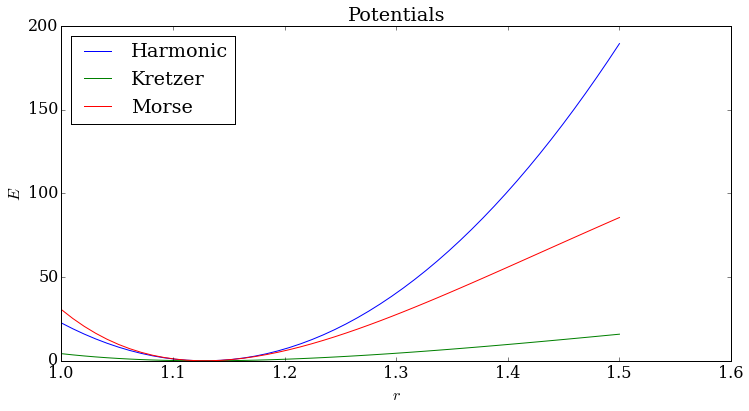

In [6]:
r = np.linspace(1, 1.5)
h = harmonic(r)
k = kretzer(r)
m = morse(r)
plt.plot(r, h, label='Harmonic')
plt.plot(r, k, label='Kretzer')
plt.plot(r, m, label='Morse')
plt.title("Potentials")
plt.xlabel(r"$r$")
plt.ylabel(r"$E$")
plt.legend(loc='upper left')
plt.show()

### Evolution

Using your velocity-Verlet integrator from lab 1, evolve the CO molecule using the Morse potential. Note that, unlike lab 1, the two particles now have different mass. It is perhaps easiest to scale it so that the carbon particle has mass $1$ and the oxygen mass $1.332029$. Do *not* use periodic boundaries! Try using $\Delta t = 0.001$ up to $t=1$. Start from the equilibrium position and show that it does not evolve. The move the location of the oxygen atom slightly and see how it evolves.

In [7]:
@jit
def dmorse(r):
    return 2 * D0 * alpha * np.exp(-alpha * (r - req)) * (np.exp(-alpha * (r - req)) - 1)

In [8]:
@jit
def part_reset(pos):
    #while np.any(pos > 0.5):
    pos[pos > 0.5] -= 1.0
    #while np.any(pos < 0.5):
    pos[pos < -0.5] += 1.0
    return pos

In [9]:
@jit
def accel(pos, mass, potential=dmorse):
    N = pos.shape[0]
    acc = np.zeros_like(pos)
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            pos_diff = pos[i, :] - pos[j, :]
            r = np.linalg.norm(pos_diff)
            dV_local = potential(r)
            acc[i, :] += pos_diff * dV_local/mass[i]
            acc[j, :] -= pos_diff * dV_local/mass[j]
    return acc

In [10]:
@jit
def vv(pos, vel, acc, mass, dt):
    N, dim = np.shape(pos)
    pos_new = pos + vel * dt + 0.5 * dt**2 * acc
    vel_star = vel + 0.5 * dt * acc
    acc_new = accel(pos_new, mass)
    vel_new = vel_star + 0.5 * dt * acc_new
    return pos_new, vel_new, acc_new

In [11]:
@jit
def temperature(vel, boxSize):
    N = vel.shape[0]
    energy = np.sum(np.einsum('ij,ji->i', vel, vel.T))
    return boxSize**2 * energy / float(3 * N)

In [12]:
@jit
def sim(init, mass, dt, steps):
    cpos = init.copy()
    all_pos = np.zeros((steps+1, cpos.shape[0], cpos.shape[1]))
    all_pos[0, :, :] = cpos
    cvel = np.zeros_like(cpos)
    cacc = np.zeros_like(cpos)
    time = np.arange(0.0, steps*dt, dt)
    time = np.append(time, steps*dt)
    T = np.zeros_like(time)
    T[0] = temperature(cvel, boxSize)
    for i in np.arange(1, steps+1):
        cpos, cvel, cacc = vv(cpos, cvel, cacc, mass, dt)
        all_pos[i, :, :] = cpos[:]
        T[i] = temperature(cvel, boxSize)
        #print "pos of first two are \n{}\n{}\n Temperature is {}\n".format(cpos[0,:], cpos[1, :], T[i])
    return all_pos, time, T

In [18]:
init = np.zeros((2, 3))
init[1, 0] = 1.15
boxSize = 6.1984
dt = 0.001
steps = 1000
rc = 2.5
mass = np.array([1, 1.332029])
pos, t, T = sim(init, mass, dt, steps)

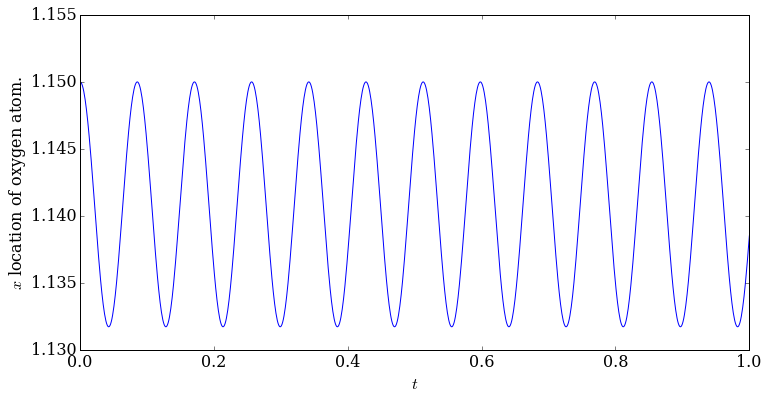

In [19]:
plt.plot(t, pos[:, 1, 0])
plt.xlabel(r"$t$")
plt.ylabel(r"$x$ location of oxygen atom.");

## Water

The paper of [Praprotnik, Janezic, and Mavri](http://dx.doi.org/10.1021/jp046158d) suggests a potential for a single water molecule (one oxygen atom and two hydrogen with atomic weights $1.008$) of

$$
\begin{equation}
  V = \sum_{l = 1}^2 D_0 \left[ 1 - e^{\alpha \Delta r_{OH_l}} \right]^2 + \frac{1}{2} k_{\theta} \Delta r_{HH}^2 + k_{r \theta} \Delta r_{HH} \left( \Delta r_{OH_1} + \Delta r_{OH_2} \right) + k_{rr} \Delta r_{OH_1} \Delta r_{OH_2}.
\end{equation}
$$

The first term is the Morse potential again, and the other terms are the intra-molecule bond potentials. $\Delta r_{OH_l} = r_{OH_l} - r_{OH_{\text{eq}}}$ is the stretch in the distance between the oxygen atom and the $l^{\text{th}}$ hydrogen atom $r_{OH_l}$ and its equilibrium value, and $\Delta r_{HH} = r_{HH_l} - r_{HH_{\text{eq}}}$ is the stretch in the distance between the hydrogen atoms. The parameter values are

1. $D_0 = 101.9188$ kcal/mol.
2. $\alpha = 2.567$ Angstrom${}^{-1}$
3. $k_{\theta} = 328.645606$ kcal/mol/Angstrom${}^2$
4. $k_{r \theta} = -211.4672$ kcal/mol/Angstrom${}^2$
5. $k_{rr} = 111.70765$ kcal/mol/Angstrom${}^2$
6. $r_{OH_{\text{eq}}} = 1$ Angstrom
7. $r_{HH_{\text{eq}}} = 1.633$ Angstrom


Fix the oxygen atom at the origin and start the hydrogen atoms at $(\pm 0.8, 0.6, 0)$. Use the minimization techniques to find the equilibrium position of the atoms, [comparing against the known structure of water](http://en.wikipedia.org/wiki/Water_model).

**NOTE**: if using `scipy`'s minimization routine, you may have to increase the tolerance as high as $10^{-4}$ to make it converge.

In [21]:
D0 = 101.9188
alpha = 2.567
k_t = 328.645606
k_rt = -211.4672
k_rr = 111.70765
r_OHeq = 1
r_HHeq = 1.633

In [55]:
@jit
def wmorse(r):
    return D0 * (1 - np.exp(-alpha * (r - r_OHeq)))**2

@jit
def mwater(r):
    """
    The vector r is considered to be built as following:
        r[0] = r_OH1
        r[1] = r_OH2
        r[2] = r_HH
    """
    assert len(r) == 3, "Please check input vector shape to be of length 3"
    droh1 = r[0] - r_OHeq
    droh2 = r[1] - r_OHeq
    drhh = r[2] - r_HHeq
    Vpart = 0.5 * k_t * drhh**2 + k_rt * drhh * (droh1 + droh2) + k_rr * droh1 * droh2
    return np.sum(wmorse(r[:2])) + Vpart

In [58]:
rinit = np.append(np.random.normal(loc=r_OHeq, scale=0.15, size=(15, 2)),
                  np.random.normal(loc=r_HHeq, scale=0.15, size=(15, 1)), axis=1)

for i in np.arange(np.shape(r)[0]):
    r = rinit[i, :]
    minima = minimize(mwater, r, tol=1e-5)
    if minima.success:
        print("Starting from {} the Morse potential found:\n Separation {}\
        \n in {} function evaluations\nand {} Jacobian evalutions".format(r, minima.x,
                                                                          minima.nfev, minima.njev))
    else:
        print("Initialisation with x = {} for the {} method failed".format(r, method))

Starting from [ 0.91902474  1.03343123  1.63795285] the Morse potential found:
 Separation [ 0.99999999  0.99999999  1.63299998]        
 in 100 function evaluations
and 20 Jacobian evalutions
Initialisation with x = [ 1.18893917  1.01914906  1.35442152] for the Morse method failed
Initialisation with x = [ 1.0953866   0.81160528  1.64391351] for the Morse method failed


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


Using your integrator, evolve the molecule and see how it behaves.

In [ ]:
@jit
def dwmorse(r):
    return 2 * D0 * alpha * np.exp(-alpha * (r - r_OHeq)) * (np.exp(-alpha * (r - r_OHeq)) - 1)

@jit 
def 

@jit
def accel(pos, mass, potential=dmorse):
    N = pos.shape[0]
    acc = np.zeros_like(pos)
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            pos_diff = pos[i, :] - pos[j, :]
            r = np.linalg.norm(pos_diff)
            dV_local = potential(r)
            acc[i, :] += pos_diff * dV_local/mass[i]
            acc[j, :] -= pos_diff * dV_local/mass[j]
    return acc

In [ ]:
init = [[0.0, 0.0, 0.0],
       [0.8, 0.6, 0.0],
       [-0.8, 0.6, 0.0]]
init = np.array(init)
dt = 0.001
steps = 1000
mass = np.array([15.9996, 1.008, 1.008])
pos, t, T = sim(init, mass, dt, steps)